**Stock Price performance and Price Prediction:**

1) Sentiment Analysis of news and tweets of a company using BERT: Test Accuracy is 80%

In [ ]:

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
import re
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
df=pd.read_csv("Reliance-final-news.csv")
df.head()

,Final
0,reliance industry o2c new energy biz may valu...
1,ril parameter rose 158% one year
2,ltâs best value play expect reliance dilip bhat
3,ril share price end flat tuesday even sensex ...
4,india reliance industry plan 10 billion clean...


In [ ]:
tokenizer=AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model=AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [ ]:
#Bert sentiment scoring
def sentiment_score(text):
  tokens=tokenizer.encode(text,return_tensors='pt')
  result=model(tokens)
  return int(torch.argmax(result.logits))+1

In [ ]:
df['sentiment']=df['Final'].apply(lambda x: sentiment_score(x))

In [ ]:
import numpy as np
np.mean(df['sentiment'])

3.73

In [ ]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  else:
    return 1
df['sentiment'] = df.sentiment.apply(to_sentiment)

In [ ]:
df.head()

,Final,sentiment
0,reliance industry o2c new energy biz may valu...,1
1,ril parameter rose 158% one year,0
2,ltâs best value play expect reliance dilip bhat,1
3,ril share price end flat tuesday even sensex ...,0
4,india reliance industry plan 10 billion clean...,1


In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline

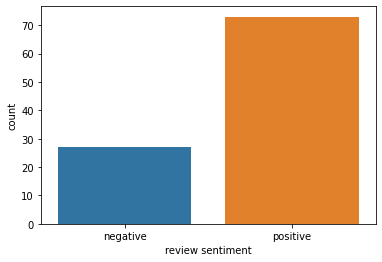

In [ ]:
class_names = ['negative','positive']
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [ ]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [ ]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [ ]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [ ]:
token_lens = []
for txt in df.Final:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


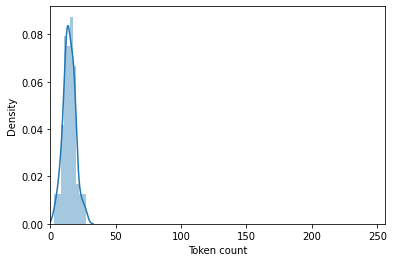

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = 50

In [ ]:
class GPReviewDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_train, df_test = train_test_split(
  df,
  test_size=0.1,
  random_state=42
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.6,
  random_state=42
)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((90, 2), (4, 2), (6, 2))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.Final.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 50])
torch.Size([16, 50])
torch.Size([16])


In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape)

torch.Size([16, 50])
torch.Size([16, 50])


In [ ]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.6381065845489502 accuracy 0.7
Val   loss 0.39006248116493225 accuracy 1.0

Epoch 2/10
----------
Train loss 0.5327882568041483 accuracy 0.7111111111111111
Val   loss 0.2517926096916199 accuracy 1.0

Epoch 3/10
----------
Train loss 0.2818979447086652 accuracy 0.8444444444444444
Val   loss 0.9780745506286621 accuracy 0.25

Epoch 4/10
----------
Train loss 0.08565814731021722 accuracy 0.9777777777777777
Val   loss 1.0823290348052979 accuracy 0.75

Epoch 5/10
----------
Train loss 0.018922224640846252 accuracy 0.9888888888888889
Val   loss 1.434558629989624 accuracy 0.75

Epoch 6/10
----------
Train loss 0.006251301946273695 accuracy 1.0
Val   loss 1.7958024740219116 accuracy 0.75

Epoch 7/10
----------
Train loss 0.0011716550313091527 accuracy 1.0
Val   loss 1.9437735080718994 accuracy 0.75

Epoch 8/10
----------
Train loss 0.001073266234016046 accuracy 1.0
Val   loss 2.0072922706604004 accuracy 0.75

Epoch 9/10
----------
Train loss 0.00078722547429303

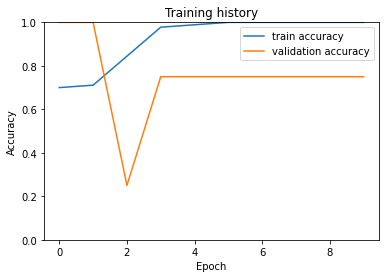

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

Testing the model: Accuracy 80%

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


0.8

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
idx = 3
review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

Classification random data using our bert model

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

 stock watch reliance industry apollo hospital tata motor

True sentiment: positive


**2) ARIMA and LSTM Model for price prediction: LSTM Performs better than arima with a very less RMSE**

In [ ]:
import numpy as np 
import pandas as pd
import lightgbm as lgb
from numpy.random import normal, seed
import math
from sklearn.metrics import mean_squared_error

from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from matplotlib import pyplot
from pylab import rcParams
from plotly import tools
import plotly.graph_objs as go
import plotly.figure_factory as ff
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from scipy.stats import norm
import scipy.stats as scs

from fbprophet import Prophet

In [ ]:
df = pd.read_csv("MARUTI.csv", parse_dates=["Date"],index_col="Date")
df.head()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2003-07-09,MARUTI,EQ,125.00,164.90,170.40,155.00,164.0,164.30,165.95,35164283,5.835528e+14,NaN,8537695.0,0.2428
2003-07-10,MARUTI,EQ,164.30,167.00,168.70,164.50,167.0,167.00,166.74,10464179,1.744820e+14,NaN,4363947.0,0.4170
2003-07-11,MARUTI,EQ,167.00,167.75,174.85,166.25,173.6,173.35,172.45,11740117,2.024622e+14,NaN,3014852.0,0.2568
2003-07-14,MARUTI,EQ,173.35,174.25,179.25,174.25,178.6,177.95,177.91,5982324,1.064313e+14,NaN,1949217.0,0.3258
2003-07-15,MARUTI,EQ,177.95,200.00,200.00,173.00,176.3,176.20,176.88,6173689,1.092001e+14,NaN,1307694.0,0.2118


Volume Weighted Average Price,the target variable to predict. VWAP is a trading benchmark used by traders that gives the average price the stock has traded at throughout the day, based on both volume and price.

In [ ]:
print("Percentage of missing trade values = {:.2f}".format(100*(df['Trades'].isna().sum())/df.shape[0]))
print("Percentage of missing Deliverable Volume values = {:.2f}".format(100*(df['Deliverable Volume'].isna().sum())/df.shape[0]))
print("Percentage of missing %Deliverble values = {:.2f}".format(100*(df['%Deliverble'].isna().sum())/df.shape[0]))

Percentage of missing trade values = 44.52
Percentage of missing Deliverable Volume values = 0.02
Percentage of missing %Deliverble values = 0.02


In [ ]:
df = df[df['Deliverable Volume'] >0]

In [ ]:
df['Trades'].ffill(axis = 0) 
trade_data = df.loc[df.index<='2021']
mean = round(trade_data['Trades'].mean(),1)
df["Trades"].fillna(value = mean,inplace = True)

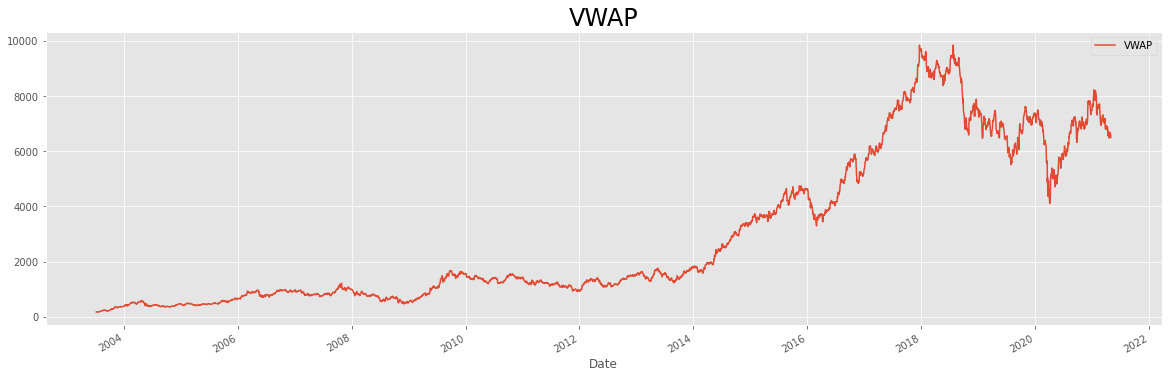

In [ ]:
ax = df[['VWAP']].plot(figsize=(20, 6))
ax.set_title('VWAP', fontsize=24);

Lambda: -0.049789


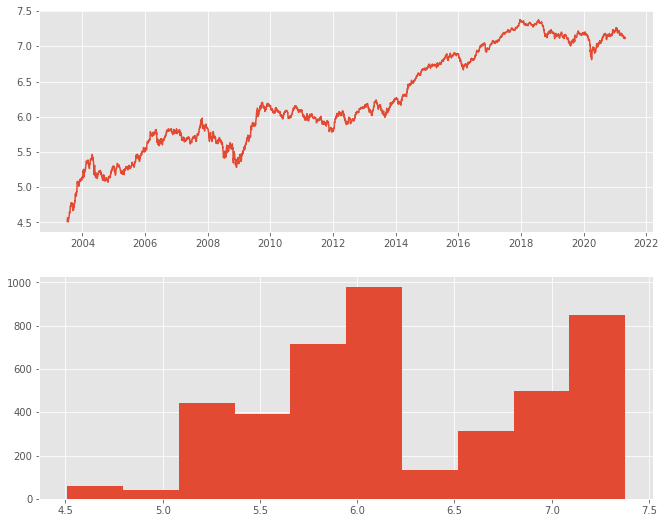

In [ ]:
from scipy.stats import boxcox
df['vwap_boxcox'],lam = boxcox(df['VWAP'])
print('Lambda: %f' % lam)
rcParams['figure.figsize'] = 11, 9
pyplot.figure(1)
# line plot
pyplot.subplot(211)
pyplot.plot(df['vwap_boxcox'])
# histogram
pyplot.subplot(212)
pyplot.hist(df['vwap_boxcox'])
pyplot.show()

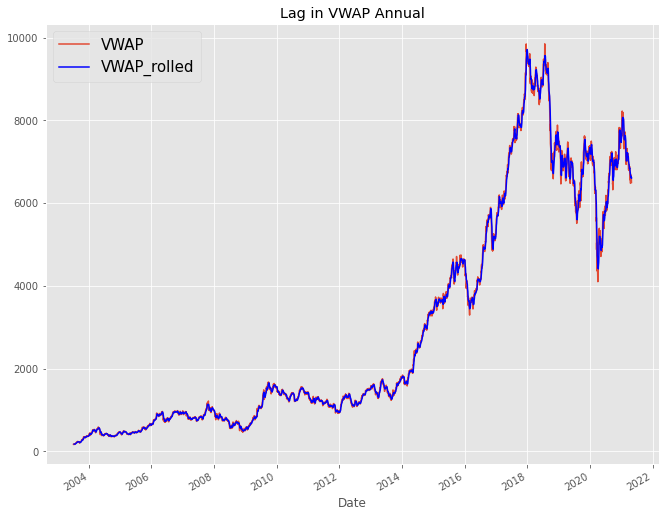

In [ ]:
rolling_vwap = df['VWAP'].rolling(window=7)
df['VWAP_rolled'] = rolling_vwap.mean()
df['VWAP'].plot() 
df['VWAP_rolled'].plot(color='blue')
plt.title('Lag in VWAP Annual')
plt.legend(fontsize=15)
pyplot.show()

In [ ]:
result = adfuller(df['VWAP'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1]) 
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.783963
p-value: 0.823787
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [ ]:
df2 = df.copy()
df2.head()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble,vwap_boxcox,VWAP_rolled
Date,,,,,,,,,,,,,,,,
2003-07-09,MARUTI,EQ,125.00,164.90,170.40,155.00,164.0,164.30,165.95,35164283,5.835528e+14,53853.7,8537695.0,0.2428,4.513057,NaN
2003-07-10,MARUTI,EQ,164.30,167.00,168.70,164.50,167.0,167.00,166.74,10464179,1.744820e+14,53853.7,4363947.0,0.4170,4.516738,NaN
2003-07-11,MARUTI,EQ,167.00,167.75,174.85,166.25,173.6,173.35,172.45,11740117,2.024622e+14,53853.7,3014852.0,0.2568,4.542816,NaN
2003-07-14,MARUTI,EQ,173.35,174.25,179.25,174.25,178.6,177.95,177.91,5982324,1.064313e+14,53853.7,1949217.0,0.3258,4.566918,NaN
2003-07-15,MARUTI,EQ,177.95,200.00,200.00,173.00,176.3,176.20,176.88,6173689,1.092001e+14,53853.7,1307694.0,0.2118,4.562431,NaN


In [ ]:
df2.reset_index(drop=False,inplace=True)
lag_features = ["High", "Low", "Volume", "Turnover", "Trades"]
window1 = 3
window2 = 7
window3 = 30

df_rolled_3d = df2[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df2[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df2[lag_features].rolling(window=window3, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    df2[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df2[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df2[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    
    df2[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df2[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df2[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

df2.fillna(df.mean(), inplace=True)

df2.set_index("Date", drop=False, inplace=True)
df2.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble,vwap_boxcox,VWAP_rolled,High_mean_lag3,High_mean_lag7,High_mean_lag30,High_std_lag3,High_std_lag7,High_std_lag30,Low_mean_lag3,Low_mean_lag7,Low_mean_lag30,Low_std_lag3,Low_std_lag7,Low_std_lag30,Volume_mean_lag3,Volume_mean_lag7,Volume_mean_lag30,Volume_std_lag3,Volume_std_lag7,Volume_std_lag30,Turnover_mean_lag3,Turnover_mean_lag7,Turnover_mean_lag30,Turnover_std_lag3,Turnover_std_lag7,Turnover_std_lag30,Trades_mean_lag3,Trades_mean_lag7,Trades_mean_lag30,Trades_std_lag3,Trades_std_lag7,Trades_std_lag30
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2003-07-09,2003-07-09,MARUTI,EQ,125.00,164.90,170.40,155.00,164.0,164.30,165.95,35164283,5.835528e+14,53853.7,8537695.0,0.2428,4.513057,2926.467075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-07-10,2003-07-10,MARUTI,EQ,164.30,167.00,168.70,164.50,167.0,167.00,166.74,10464179,1.744820e+14,53853.7,4363947.0,0.4170,4.516738,2926.467075,170.399994,170.399994,170.399994,NaN,NaN,NaN,155.000000,155.000000,155.000000,NaN,NaN,NaN,35164284.0,35164284.0,35164284.0,NaN,NaN,NaN,5.835528e+14,5.835528e+14,5.835528e+14,NaN,NaN,NaN,53853.699219,53853.699219,53853.699219,NaN,NaN,NaN
2003-07-11,2003-07-11,MARUTI,EQ,167.00,167.75,174.85,166.25,173.6,173.35,172.45,11740117,2.024622e+14,53853.7,3014852.0,0.2568,4.542816,2926.467075,169.550003,169.550003,169.550003,1.202082,1.202082,1.202082,159.750000,159.750000,159.750000,6.717515,6.717515,6.717515,22814232.0,22814232.0,22814232.0,17465612.0,17465612.0,17465612.0,3.790174e+14,3.790174e+14,3.790174e+14,2.892568e+14,2.892568e+14,2.892568e+14,53853.699219,53853.699219,53853.699219,0.0,0.0,0.0
2003-07-14,2003-07-14,MARUTI,EQ,173.35,174.25,179.25,174.25,178.6,177.95,177.91,5982324,1.064313e+14,53853.7,1949217.0,0.3258,4.566918,2926.467075,171.316666,171.316666,171.316666,3.175820,3.175820,3.175820,161.916672,161.916672,161.916672,6.053580,6.053580,6.053580,19122860.0,19122860.0,19122860.0,13906921.0,13906921.0,13906921.0,3.201657e+14,3.201657e+14,3.201657e+14,2.285286e+14,2.285286e+14,2.285286e+14,53853.699219,53853.699219,53853.699219,0.0,0.0,0.0
2003-07-15,2003-07-15,MARUTI,EQ,177.95,200.00,200.00,173.00,176.3,176.20,176.88,6173689,1.092001e+14,53853.7,1307694.0,0.2118,4.562431,2926.467075,174.266663,173.300003,173.300003,5.299135,4.739022,4.739022,168.333328,165.000000,165.000000,5.198157,7.903059,7.903059,9395540.0,15837726.0,15837726.0,3023993.5,13118818.0,13118818.0,1.611251e+14,2.667321e+14,2.667321e+14,4.938911e+13,2.150290e+14,2.150290e+14,53853.699219,53853.699219,53853.699219,0.0,0.0,0.0


In [ ]:
df2.Date = pd.to_datetime(df2.Date, format="%Y-%m-%d")
df2["month"] = df2.Date.dt.month
df2["day"] = df2.Date.dt.day

In [ ]:
df2.dropna(axis =0,inplace=True)
#Dropping NULL or infinite values to avoid errors.
df2 =df2[~df2.isin([np.nan, np.inf, -np.inf]).any(1)]
df2=df2.resample('MS').sum()
df_train = df2[df2.index < "2021"]
df_valid = df2[df2.index >= "2021"]

exogenous_features = ["High_mean_lag3", "High_std_lag3", "Low_mean_lag3", "Low_std_lag3",
                      "Volume_mean_lag3", "Volume_std_lag3", "Turnover_mean_lag3",
                      "Turnover_std_lag3", "Trades_mean_lag3", "Trades_std_lag3",
                      "High_mean_lag7", "High_std_lag7", "Low_mean_lag7", "Low_std_lag7",
                      "Volume_mean_lag7", "Volume_std_lag7", "Turnover_mean_lag7",
                      "Turnover_std_lag7", "Trades_mean_lag7", "Trades_std_lag7",
                      "High_mean_lag30", "High_std_lag30", "Low_mean_lag30", "Low_std_lag30",
                      "Volume_mean_lag30", "Volume_std_lag30", "Turnover_mean_lag30",
                      "Turnover_std_lag30", "Trades_mean_lag30", "Trades_std_lag30",
                      "month", "day"]

In [ ]:
df3 = pd.DataFrame()
df3['VWAP'] = df2['VWAP']
for i in exogenous_features:
    df3[i] = df2[i]
print(pd.infer_freq(df3.index, warn=True))

MS


In [ ]:
from statsmodels.tsa.ar_model import AutoReg
model = AutoReg(df3.VWAP,lags=3, exog=df3[exogenous_features])
res = model.fit()
print(res.summary())
print("μ={} ,ϕ={}".format(res.params[0],res.params[1]))

                            AutoReg Model Results                             
Dep. Variable:                   VWAP   No. Observations:                  214
Model:                   AutoReg-X(3)   Log Likelihood               -1379.883
Method:               Conditional MLE   S.D. of innovations            167.468
Date:                Mon, 19 Jul 2021   AIC                             10.592
Time:                        19:10:29   BIC                             11.180
Sample:                    10-01-2003   HQIC                            10.830
                         - 04-01-2021                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
intercept               0.0159      0.007      2.181      0.029       0.002       0.030
VWAP.L1                 0.0013      0.002      0.660      0.509      -0.003       0.005
VWAP.L2         

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 



In [ ]:
res = model.fit(cov_type="HC0")
print(res.summary())
print("μ={} ,ϕ={}".format(res.params[0],res.params[1]))

                            AutoReg Model Results                             
Dep. Variable:                   VWAP   No. Observations:                  214
Model:                   AutoReg-X(3)   Log Likelihood               -1379.883
Method:               Conditional MLE   S.D. of innovations            167.468
Date:                Mon, 19 Jul 2021   AIC                             10.592
Time:                        19:10:33   BIC                             11.180
Sample:                    10-01-2003   HQIC                            10.830
                         - 04-01-2021                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
intercept               0.0159      0.009      1.854      0.064      -0.001       0.033
VWAP.L1                 0.0013      0.003      0.443      0.658      -0.004       0.007
VWAP.L2         

In [ ]:
rmse = math.sqrt(mean_squared_error(df3['VWAP'].loc['2014-01-01':'2021-01-04'],res.predict(start='2014-01-01',end='2020-11-01') ))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 230.69062679075083.


In [ ]:
pip install pmdarima

     |████████████████████████████████| 1.5 MB 4.0 MB/s 


In [ ]:
from pmdarima.arima import auto_arima
model = auto_arima(df_train.VWAP, exogenous=df_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train.VWAP, exogenous=df_train[exogenous_features])

forecast = model.predict(n_periods=len(df_valid), exogenous=df_valid[exogenous_features])
df_valid["Forecast_ARIMAX"] = forecast

Performing stepwise search to minimize aic


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1890: RuntimeWarning:

divide by zero encountered in reciprocal

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1897: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2815.225, Time=1.26 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2807.087, Time=0.61 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2797.559, Time=0.63 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2795.240, Time=1.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3718.983, Time=0.56 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2796.711, Time=1.05 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=2796.762, Time=1.16 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2817.282, Time=1.24 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2793.244, Time=1.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2794.708, Time=1.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2794.762, Time=1.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2795.564, Time=0.61 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2814.795, Time=1.14 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 12.527 seconds


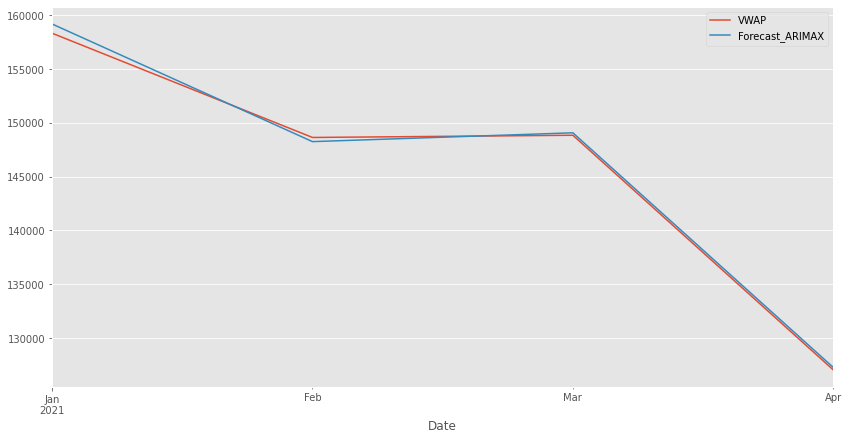

In [ ]:
df_valid[["VWAP", "Forecast_ARIMAX"]].plot(figsize=(14, 7))

RMSE of Arima model is high

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_ARIMAX)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_ARIMAX))

RMSE of Auto ARIMAX: 498.2726304057678

MAE of Auto ARIMAX: 426.437685349003


**LSTM Model:**

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RNN
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
from math import sqrt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
df4=df3.copy()

In [ ]:
dataset = df4.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
X_train = train[:,1:]
y_train = train[:,0]
X_test = test[:,1:]
y_test = test[:,0]

In [ ]:
batch_size = 1
timesteps = 1
units = 100
nb_epoch = 70

In [ ]:
X_train = X_train.reshape(X_train.shape[0],timesteps,X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0],timesteps,X_test.shape[1])

In [ ]:
model = Sequential()
model.add(LSTM(units,batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history=model.fit(X_train, y_train,epochs=nb_epoch,batch_size=batch_size, validation_data=(X_test, y_test),callbacks=[EarlyStopping(monitor='val_loss', patience=21)],verbose=0,shuffle=False)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, 100)                  53200     
_________________________________________________________________
dense (Dense)                (1, 1)                    101       
Total params: 53,301
Trainable params: 53,301
Non-trainable params: 0
_________________________________________________________________


RMSE of LSTM is very less compared to Arima; 0.116 only

In [ ]:
yhat = model.predict(X_test, batch_size=batch_size)
rmse = sqrt(mean_squared_error(y_test, yhat))
mae=mean_absolute_error(y_test, yhat)
print('rmse:{} MAE:{}'.format(rmse,mae))

rmse:0.11612750111510316 MAE:0.10493119060993195


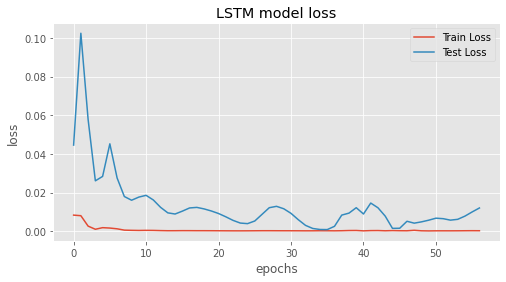

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

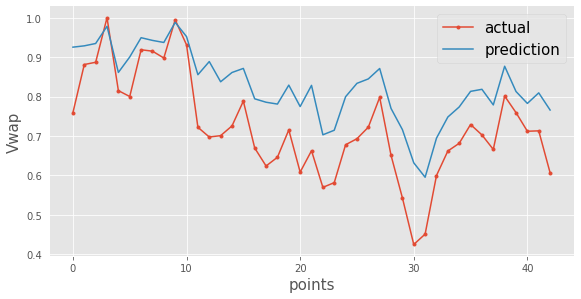

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(y_test, marker='.', label="actual")
plt.plot(yhat, label="prediction")
plt.tick_params(left=False, labelleft=True)
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Vwap', size=15)
plt.xlabel('points', size=15)
plt.legend(fontsize=15)
plt.show();